In [1]:
"""
Created on Tue May 24 13:23:13 2023

@author: Guido Pagano
Compute the time evolution of the ising coulping with a complete Hamiltonian and
compare the result under a pure spin interaction approximation
"""
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
import Qsim.operator.spin as spin
import Qsim.operator.phonon as phon
import Qsim.ion_chain.ising.ising_ps as iscp
import Qsim.ion_chain.ising.ising_c as iscc
import Qsim.ion_chain.transfer.exci_operators as exop
from  Qsim.ion_chain.ion_system import *
from scipy import signal

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
'''set parameters of the system'''    
ion_sys = ions()
N = 2
ion_sys.N = N # 2 ion system 
ion_sys.fz = 1.1; #axial COM (Confining) frequency MHz
ion_sys.fx= 3.18; #transverse COM (Confining) frequency MHz
ion_sys.fr  = 12 #side band rabi frequency kHz
ion_sys.fb  = 12 
ion_sys.active_phonon = [[0,1]] # phonons active
ion_sys.pcut = [[3,3]] # phonon cutoffs
#delta = float(input("Enter detuning frequency (kHz): "))
ion_sys.delta_ref = 0 #detuning from com
delta = 30 #detuning from com mode
ion_sys.delta = delta
ion_sys.df_laser = 1 #Coupled to Radial
ion_sys.laser_couple = [0,1] #laser coupled to both ions
ion_sys.list_para() #print parameters of the system
ion_sys.check_phonon()
Bz = 0 #Effective magnetic field

________________________________________________________________
********************Setup of the Trap************************
number of ions 2
axial COM (Confining) frequency  1.1  [MHz]
transverse COM (Confining) frequency  3.18 [MHz]
index of ions that couple to the laser field:  [0, 1]
Axial vibrational eigenfrequency [1.1  1.91] MHz
Transverse(Radial) vibrational eigenfrequency [3.18 2.98] MHz
                                                                 
********************Parameters of Laser Drive************************
Vibrational degree of freedom couples to the laser: Transverse (Radial)
detuning delta (measured as deviation from transverseCOM freq 30  [kHz]
detuning from eigenfrequency [ 30.   226.31] kHz
detuning frequency index:  0
red side band rabi frequency  12  [kHz]
blue side band rabi frequency  12  [kHz]
Estimated spin-phonon coupling strength: 8.49  [kHz]
                                                                 
********************Config of Numeric Ca

In [13]:
'''
simulation for complete Hamiltonian
'''
#construct Hamiltonian 
Heff,arg0 = iscc.H_ord(Bz,ion_sys) #construct time-dependent H
#construct initial state (0,0 = up up)
spin_config = np.array([1,1])
spin_config = spin.spin_state(N,[1,1])
print(spin_config)
psi1 = exop.ini_state(ion_sys,spin_config,[[0,0]],1)
#elist1 = [tensor(spin.sz(N,0),exop.p_I(ion_sys)),tensor(spin.sz(N,1),exop.p_I(ion_sys))]
elist1 = []
for i in range(N): 
    elist1.append( tensor(spin.sz(N,i),exop.p_I(ion_sys)) )

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]


In [14]:
#solve time dependent SE
times =  np.arange(0,2,10**(-4))
print('______________________________________________________________________')
print('solving for complete Hamiltonian')
complete = sesolve(Heff,psi1,times,e_ops=elist1,args = arg0,progress_bar=True,options=Options(nsteps=1000)) 

______________________________________________________________________
solving for complete Hamiltonian
10.0%. Run time:   0.32s. Est. time left: 00:00:00:02
20.0%. Run time:   0.62s. Est. time left: 00:00:00:02
30.0%. Run time:   0.93s. Est. time left: 00:00:00:02
40.0%. Run time:   1.24s. Est. time left: 00:00:00:01
50.0%. Run time:   1.55s. Est. time left: 00:00:00:01
60.0%. Run time:   1.85s. Est. time left: 00:00:00:01
70.0%. Run time:   2.16s. Est. time left: 00:00:00:00
80.0%. Run time:   2.47s. Est. time left: 00:00:00:00
90.0%. Run time:   2.77s. Est. time left: 00:00:00:00
Total run time:   3.09s


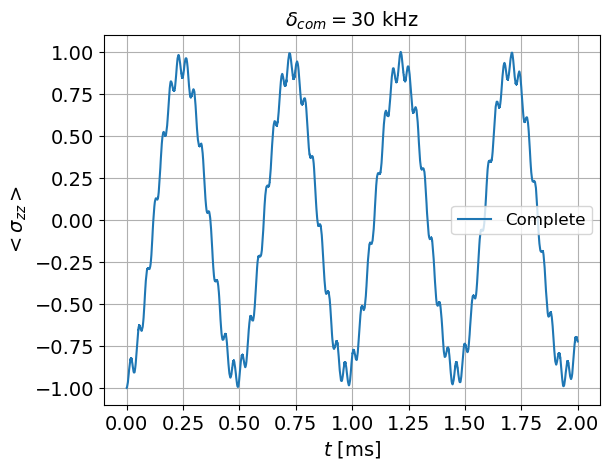

In [15]:
p1 = 0.5*(complete.expect[0]+complete.expect[1])
plt.plot(times,p1,label = 'Complete')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
title = r'$\delta_{com} = $'+str(delta)+' kHz'
plt.ylabel(r'$<\sigma_{zz}>$',fontsize = 14)
plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()

In [9]:
'''simulation with a pure spin approximation'''
psi0 = spin.phid(N)
psi0 = spin.spin_state(2,[1,1])
J = iscp.Jt(ion_sys)
elist2 = [spin.sz(N,0),spin.sz(N,1)]
H = iscp.Hps(J,ion_sys,Bz)
print('______________________________________________________________________')
print('solving for pure spin interaction')
spinres = mesolve(H,psi0,times,e_ops=elist2,progress_bar=True, options=Options(nsteps=1000))

______________________________________________________________________
solving for pure spin interaction
10.0%. Run time:   0.08s. Est. time left: 00:00:00:00
20.0%. Run time:   0.14s. Est. time left: 00:00:00:00
30.0%. Run time:   0.19s. Est. time left: 00:00:00:00
40.0%. Run time:   0.25s. Est. time left: 00:00:00:00
50.0%. Run time:   0.31s. Est. time left: 00:00:00:00
60.0%. Run time:   0.36s. Est. time left: 00:00:00:00
70.0%. Run time:   0.42s. Est. time left: 00:00:00:00
80.0%. Run time:   0.48s. Est. time left: 00:00:00:00
90.0%. Run time:   0.54s. Est. time left: 00:00:00:00
Total run time:   0.59s


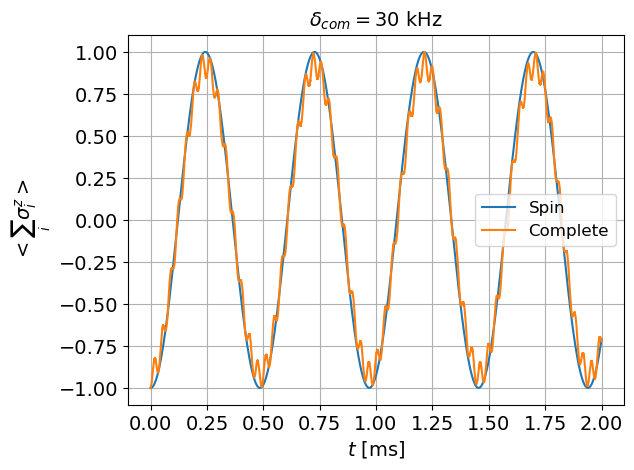

In [10]:
p2 = 0.5*(spinres.expect[0]+spinres.expect[1])
title = r'$\delta_{com} = $'+str(delta)+' kHz'
plt.plot(times,p2,label = 'Spin')
plt.plot(times,p1,label = 'Complete')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
plt.ylabel(r'$<\sum_i\sigma^z_{i}>$',fontsize = 14)
plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()